# Sentiment Analysis using Bidirectional LSTM and Keras

In [1]:
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re
import tensorflow as tf
import pandas as pd

In [2]:
data = pd.read_csv('/content/drive/MyDrive/nlp/IMDB Dataset.csv')


print(data)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/nlp/IMDB Dataset.csv'

In [3]:

import nltk
nltk.download('stopwords')
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and Clean Dataset
In the original dataset, the reviews are still dirty. There are still html tags, numbers, uppercase, and punctuations. This will not be good for training, so in load_dataset() function, beside loading the dataset using pandas, I also pre-process the reviews by removing html tags, non alphabet (punctuations and numbers), stop words, and lower case all of the reviews.

## Encode Sentiments
In the same function, I also encode the sentiments into integers (0 and 1). Where 0 is for negative sentiments and 1 is for positive sentiments.

In [5]:

def load_dataset():
    df = pd.read_csv('/content/drive/MyDrive/nlp/IMDB Dataset.csv')

    x_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    print(x_data)
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

    x_data=x_data.apply(lambda x: ' '.join(x))





    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

x_data, y_data = load_dataset()

print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/nlp/IMDB Dataset.csv'

## Split Dataset


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
34177    much adult children chagrin nearly immediately...
25307    i remember forced yes literally forced see fil...
34843    a nice shirely temple short child actors screa...
37639    i know whether film hits heart way feelings fr...
38213    warning spoilers five young people ignore warn...
                               ...                        
38786    maddy debbie rochon mentally unstable young wo...
22064    i always fascinated ninjistsu would know go be...
7314     i trying picture pitch dark angel i thinking m...
36876    this movie one best i ever seen just day i rem...
48548    hardware wars rips everything star wars but pl...
Name: review, Length: 40000, dtype: object 

26779    spoilers this movie called eaten alive uk quit...
27634    poor jane austen ought glad around see dreadfu...
34455    somewhere buried deep inside film half way dec...
2149     i saw film without knowing much the split scre...
25911    this third three stooges short team ever made ...
 

In [ ]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

## Tokenize and Pad/Truncate Reviews

A Neural Network only accepts numeric data, so we need to encode the reviews. I use tensorflow.keras.preprocessing.text.Tokenizer to encode the reviews into integers, where each unique word is automatically indexed (using fit_on_texts method) based on x_train.
x_train and x_test is converted into integers using texts_to_sequences method.

Each reviews has a different length, so we need to add padding (by adding 0) or truncating the words to the same length (in this case, it is the mean of all reviews length) using tensorflow.keras.preprocessing.sequence.pad_sequences.

post, pad or truncate the words in the back of a sentence
pre, pad or truncate the words in front of a sentence

In [ ]:

print(x_train)
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

34177    much adult children chagrin nearly immediately...
25307    i remember forced yes literally forced see fil...
34843    a nice shirely temple short child actors screa...
37639    i know whether film hits heart way feelings fr...
38213    warning spoilers five young people ignore warn...
                               ...                        
38786    maddy debbie rochon mentally unstable young wo...
22064    i always fascinated ninjistsu would know go be...
7314     i trying picture pitch dark angel i thinking m...
36876    this movie one best i ever seen just day i rem...
48548    hardware wars rips everything star wars but pl...
Name: review, Length: 40000, dtype: object
Encoded X Train
 [[   17  1104   319 ... 56951  4526  1873]
 [    1   280   812 ...     0     0     0]
 [   40   237 56952 ...     0     0     0]
 ...
 [    1   170   327 ...     0     0     0]
 [    8     3     5 ...     0     0     0]
 [10690  1590  7439 ...     0     0     0]] 

Encoded X Test
 [[ 959   

## Build Architecture/Model

**Embedding Layer:** in simple terms, it creates word vectors of each word in the word_index and group words that are related or have similar meaning by analyzing other words around them.

**BIDIRECTIONAL LSTM Layer:** to make a decision to keep or throw away data by considering the current input, previous output, and previous memory. There are some important components in LSTM.

- **Forget Gate**, decides information is to be kept or thrown away
- Input Gate, updates cell state by passing previous output and current input into sigmoid activation function
- **Cell State**, calculate new cell state, it is multiplied by forget vector (drop value if multiplied by a near 0), add it with the output from input gate to update the cell state value.
- **Ouput Gate**, decides the next hidden state and used for predictions

**Dense Layer:** compute the input with the weight matrix and bias (optional), and using an activation function. I use Sigmoid activation function for this work because the output is only 0 or 1.

The optimizer is Adam and the loss function is Binary Crossentropy because again the output is only 0 and 1, which is a binary number.

In [ ]:
print(x_train_array)
print(x_train_array.shape)

In [ ]:
from tensorflow.keras.utils import plot_model
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D,Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
model2 = Sequential()
model2.add(Embedding(input_dim=total_words, output_dim=128,input_length = max_length))  # Input layer
model2.add(Bidirectional(LSTM(units=64, return_sequences=True)))  # Bidirectional LSTM layer
model2.add(Dropout(0.5))  # Dropout layer for regularization
model2.add(Bidirectional(LSTM(units=32)))  # Bidirectional LSTM layer
model2.add(Dropout(0.5))  # Dropout layer for regularization
model2.add(Dense(units=1, activation='sigmoid'))  # Output layer
plot_model(model2, to_file='/content/drive/MyDrive/nlp/modelLSTM.png')
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 130, 128)          11812480  
                                                                 
 bidirectional_2 (Bidirecti  (None, 130, 128)          98816     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 130, 128)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/nlp/LSTM_2.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
model2.fit(x_train, y_train, epochs=5, batch_size=128,callbacks=[checkpoint])


Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8277
Epoch 1: accuracy improved from -inf to 0.82772, saving model to /content/drive/MyDrive/nlp/LSTM_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 547s 2s/step - loss: 0.3870 - accuracy: 0.8277
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9378
Epoch 2: accuracy improved from 0.82772 to 0.93785, saving model to /content/drive/MyDrive/nlp/LSTM_2.h5
313/313 [==============================] - 379s 1s/step - loss: 0.1763 - accuracy: 0.9378
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9722
Epoch 3: accuracy improved from 0.93785 to 0.97225, saving model to /content/drive/MyDrive/nlp/LSTM_2.h5
313/313 [==============================] - 367s 1s/step - loss: 0.0870 - accuracy: 0.9722
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9802
Epoch 4: accuracy improved from 0.97225 to 0.98018, saving model to /content/drive/MyDrive/nlp/LSTM_2.h5
313/313 [==============================] - 368s 1s/step - loss: 0.0631 - accuracy: 0.9802
Epoch 5/5
313/313 [=====================


## Testing

To evaluate the model, we need to predict the sentiment using our **x_test** data and comparing the predictions with y_test (expected output) data. Then, we calculate the accuracy of the model by dividing numbers of correct prediction with the total data. Resulted an accuracy of **86.63%**

In [ ]:
import numpy as np


y_pred = (model2.predict(x_test) > 0.5).astype("int32")

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))


313/313 [==============================] - 28s 86ms/step
Correct Prediction: 8676
Wrong Prediction: 1324
Accuracy: 86.76


## Load Saved Model

Load saved model and use it to predict a movie review statement's sentiment (positive or negative)

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/nlp/LSTM_2.h5')

Receives a review as an input to be predicted

# Testing this on tweet data

In [ ]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences


!pip install transformers command
from transformers import BertTokenizer, TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

  Preparing metadata (setup.py) ... done
  Created wheel for command: filename=Command-0.1.0-py3-none-any.whl size=6411 sha256=70df18331de6736a86b90ac46b90dbc474deae2372306bfc7be908dc022236d4
  Stored in directory: /root/.cache/pip/wheels/6c/b8/cc/8c02c7085edb6f28dd96e85d2831fd534c53eeaf112aa6a444
Successfully built command


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
loaded_model = load_model('/content/drive/MyDrive/nlp/LSTM_2.h5')

In [ ]:
biden_df = pd.read_csv('/content/drive/MyDrive/nlp/cleaned_sample_100_biden.csv')
trump_df = pd.read_csv('/content/drive/MyDrive/nlp/cleaned_sample_100_trump.csv')

In [ ]:
biden_df.loc[:,'who'] = 'biden'
trump_df.loc[:,'who'] = 'trump'

balance_data_df = pd.DataFrame(columns=trump_df.columns)
balance_data_df

,tweet,long,lat,state_code,sentiment,who


In [ ]:
states_list = set(biden_df['state_code']).union(set(trump_df['state_code'])) - set(['MP', 'GU', 'PR', 'VI', 'AS', 'UM', ])

In [ ]:
for state in states_list:
    trump_df_state = trump_df[trump_df['state_code']==state]
    biden_df_state = biden_df[biden_df['state_code']==state]

    n_sample = len(trump_df_state) if len(trump_df_state) < len(biden_df_state) else len(biden_df_state)

    if len(trump_df_state) < len(biden_df_state):
        balance_data_df = pd.concat([balance_data_df, trump_df_state])
        balance_data_df = pd.concat([balance_data_df, biden_df_state.sample(len(trump_df_state))])
    else:
        balance_data_df = pd.concat([balance_data_df, biden_df_state])
        balance_data_df = pd.concat([balance_data_df, trump_df_state.sample(len(biden_df_state))])

In [ ]:
balance_data_df

,tweet,long,lat,state_code,sentiment,who
229,"On GMC At this hour counting continues, Trump ...",-78.890041,33.695646,SC,0,biden
341,CrookedHillary CrookedJoeBiden Trump,-80.436374,33.687439,SC,0,biden
470,Biden Trump,-79.940273,32.787601,SC,0,biden
502,Busy night in Georgia for ballot counters who ...,-80.436374,33.687439,SC,0,biden
628,2020Election as clean amp clear as NY snow... ...,-78.890041,33.695646,SC,0,biden
...,...,...,...,...,...,...
4553,lk sonular ElectionNight DonaldTrump JoeBiden,-74.404162,40.075738,NJ,0,trump
16970,America is a winner today as long a crooked Hi...,-74.404162,40.075738,NJ,0,trump
14016,realDonaldTrump You voted for JoeBiden too? Co...,-74.404162,40.075738,NJ,0,trump
12842,Criminals Biden,-74.574600,39.277616,NJ,0,trump


In [ ]:
batch_size = 100

In [ ]:
p_data = balance_data_df['tweet']       # Reviews/Input


# PRE-PROCESS REVIEW
p_data = p_data.replace({'<.*?>': ''}, regex = True)          # remove html tag

p_data = p_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
p_data = p_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
p_data = p_data.apply(lambda review: [w.lower() for w in review])   # lower case

p_data=p_data.apply(lambda x: ' '.join(x))
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
print(p_data)
token.fit_on_texts(p_data)
print("hello",p_data)
p_data = token.texts_to_sequences(p_data)




p_train = pad_sequences(p_data, maxlen=max_length, padding='post', truncating='post')

balance_data_df["sentiment"]=(model2.predict(p_train) > 0.5).astype("int32")



229      on gmc at hour counting continues trump declar...
341                   crookedhillary crookedjoebiden trump
470                                            biden trump
502      busy night georgia ballot counters added thous...
628      election clean amp clear ny snow election elec...
                               ...                        
4553         lk sonular electionnight donaldtrump joebiden
16970    america winner today long crooked hillaryclint...
14016    realdonaldtrump you voted joebiden congratulat...
12842                                      criminals biden
14390    erictrump the gop distancing crazy family time...
Name: tweet, Length: 24572, dtype: object
hello 229      on gmc at hour counting continues trump declar...
341                   crookedhillary crookedjoebiden trump
470                                            biden trump
502      busy night georgia ballot counters added thous...
628      election clean amp clear ny snow election elec...
        

In [ ]:
balance_data_df.to_csv('/content/drive/MyDrive/nlp/balance_data_with_sentiments.csv', index=False, header=True)

balance_data_df

,tweet,long,lat,state_code,sentiment,who
229,"On GMC At this hour counting continues, Trump ...",-78.890041,33.695646,SC,0,biden
341,CrookedHillary CrookedJoeBiden Trump,-80.436374,33.687439,SC,0,biden
470,Biden Trump,-79.940273,32.787601,SC,1,biden
502,Busy night in Georgia for ballot counters who ...,-80.436374,33.687439,SC,0,biden
628,2020Election as clean amp clear as NY snow... ...,-78.890041,33.695646,SC,0,biden
...,...,...,...,...,...,...
4553,lk sonular ElectionNight DonaldTrump JoeBiden,-74.404162,40.075738,NJ,1,trump
16970,America is a winner today as long a crooked Hi...,-74.404162,40.075738,NJ,1,trump
14016,realDonaldTrump You voted for JoeBiden too? Co...,-74.404162,40.075738,NJ,0,trump
12842,Criminals Biden,-74.574600,39.277616,NJ,0,trump


<Axes: xlabel='who'>

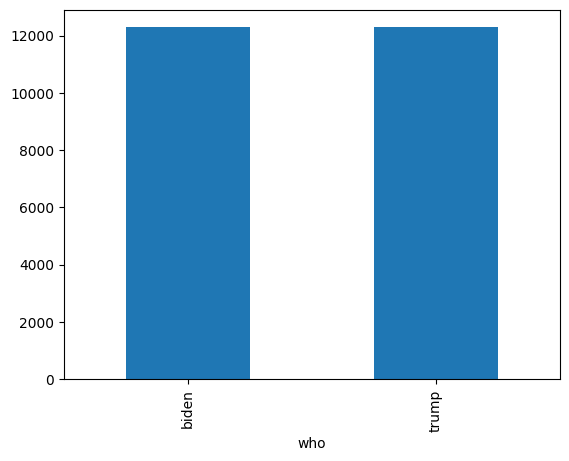

In [ ]:
balance_data_df['who'].value_counts().plot(kind='bar')

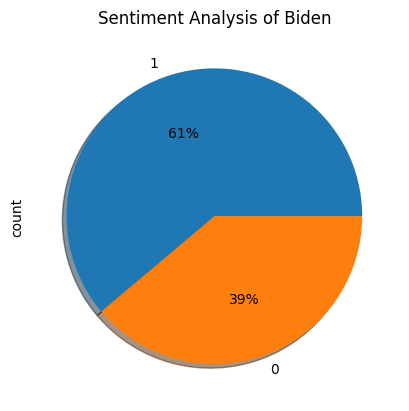

In [ ]:
balance_data_df[balance_data_df['who'] == 'biden']['sentiment'].value_counts().plot(kind='pie',autopct='%.0f%%',shadow=True)
plt.title("Sentiment Analysis of Biden")
plt.show()

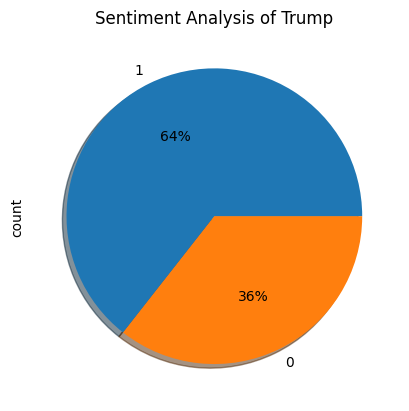

In [ ]:
balance_data_df[balance_data_df['who'] == 'trump']['sentiment'].value_counts().plot(kind='pie',shadow=True,autopct='%.0f%%')
plt.title("Sentiment Analysis of Trump")
plt.show()